# **Prueba de análisis de respuestas presentadas por cada uno de los modelos**

Despues de haber realizado la prueba de los modelos, se procede a analizar las respuestas obtenidas por cada uno de ellos. Para ello, se utilizará el archivo `pruebas_base_analisis_respuestas.csv` que contiene las respuestas generadas por cada modelo.

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import torch
import spacy


# Importemos librerias para analizar las respuestas
import re # Expresiones regulares
import nltk # Procesamiento de lenguaje natural
import spacy # Procesamiento de lenguaje natural
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm


In [113]:
nltk.download('stopwords', quiet=True) # Descargamos las stopwords de nltk
#usemos una lista de stopwords en español
stopwords_es = set(stopwords.words('spanish'))

### Funciones para anlisis y visualización de las respuestas

In [114]:
#Funciones para limpiar y procesar las respuestas

# Función para limpiar texto
def limpiar_texto(texto):
    if pd.isnull(texto):
        return ""
    # Eliminar markdown (**negrita**)
    texto = re.sub(r'\*\*(.*?)\*\*', r'\1', texto)
    # Eliminar emojis y caracteres especiales (excepto letras, números y puntuación básica)
    texto = re.sub(r'[^\w\s.,!?áéíóúÁÉÍÓÚñÑ]', '', texto)
    # Eliminar signos de puntuación
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    # Eliminar espacios múltiples
    texto = re.sub(r'\s+', ' ', texto)
    return texto.strip()

# Función para contar palabras
def contar_palabras(texto):
    palabras = texto.split()
    return len(palabras)

# Función para aplicar preprocesamiento y contar palabras en cada columna de pregunta
def procesar_respuestas(df):
    preguntas = [col for col in df.columns if col.startswith("Pregunta")]
    for pregunta in preguntas:
        df[f'{pregunta}_limpia'] = df[pregunta].apply(limpiar_texto)
        df[f'{pregunta}_conteo'] = df[f'{pregunta}_limpia'].apply(contar_palabras)
    return df

In [115]:
#Visualización de las respuestas

# Función para graficar el total de palabras por modelo y por pregunta
def graficar_palabras_por_modelo(df):
    preguntas = [col for col in df.columns if col.endswith("_conteo")]
    conteos = df.groupby("Modelo")[preguntas].sum()

    # Crear gráfico de barras apiladas
    conteos.T.plot(kind='bar', stacked=True, figsize=(12, 7))
    plt.title("Conteo de palabras por modelo y pregunta")
    plt.ylabel("Número de palabras")
    plt.xlabel("Preguntas")
    plt.xticks([], [])
    plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


def graficar_relevancia_lineas(similitud_df):
    """
    Grafica la relevancia (similitud semántica) por IA para cada pregunta.

    :param similitud_df: DataFrame con la columna 'Pregunta' y columnas de IAs con similitudes.
    """
    ia_names = similitud_df.columns[1:]  # omitir la columna 'Pregunta'
    num_preguntas = len(similitud_df)

    plt.figure(figsize=(10, 6))

    for i in range(num_preguntas):
        valores = similitud_df.iloc[i, 1:].values  # similitudes por IA
        plt.plot(ia_names, valores, marker='o', label=f'Pregunta {i+1}')

    plt.xlabel('IA')
    plt.ylabel('Relevancia (Similitud de coseno)')
    plt.title('Relevancia de las respuestas por IA (por pregunta)')
    plt.ylim(0.55, 0.9)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # leyenda fuera del gráfico
    plt.tight_layout()
    plt.show()


In [116]:
# Carga el modelo SBERT
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # o prueba con 'all-MiniLM-L6-v2' para más calidad

def calcular_similitud(preguntas_df, respuestas_df, col_pregunta='Pregunta', respuesta_prefix='Pregunta'):
    """
    Calcula la similitud semántica entre cada pregunta y las respuestas dadas por diferentes IAs.

    :param preguntas_df: DataFrame con las preguntas originales.
    :param respuestas_df: DataFrame con las respuestas limpias por IA.
    :param col_pregunta: Nombre de la columna que contiene las preguntas.
    :param respuesta_prefix: Prefijo común de las columnas de respuesta.
    :return: DataFrame con las similitudes de coseno entre cada pregunta y sus respuestas.
    """
    resultados = preguntas_df[[col_pregunta]].copy()

    for ia in respuestas_df.index:
        ia_name = respuestas_df.iloc[ia, 0]  # Nombre de la IA (ej: 'Gemini')
        similitudes = []

        for i in range(len(preguntas_df)):
            pregunta = preguntas_df.loc[i, col_pregunta]
            respuesta = respuestas_df.loc[ia, f'{respuesta_prefix} {i+1}_limpia']

            # Embeddings
            embeddings = model.encode([pregunta, respuesta])
            cos_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
            similitudes.append(cos_sim)

        resultados[ia_name] = similitudes

    return resultados

nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()

def analizar_sentimiento_vader(texto):
    """
    Analiza el sentimiento con VADER y devuelve la categoría dominante.
    """
    scores = vader_analyzer.polarity_scores(texto)
    compound = scores['compound']
    if compound >= 0.05:
        return 'Positivo'
    elif compound <= -0.05:
        return 'Negativo'
    else:
        return 'Neutro'


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jjlondono/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [117]:
base_datos= pd.read_csv('prueba_base_analisis_respuestas.csv')
base_datos= base_datos.dropna() # Eliminamos las filas con valores nulos
# Mostramos las primeras filas de la base de datos
base_datos.head(10)

,AI,Pais,Ciudad,Modelo,Pregunta 1,Pregunta 2,Pregunta 3,Pregunta 4,Pregunta 5,Pregunta 6,Pregunta 7,Pregunta 8,Pregunta 9,Pregunta 10
0,Gemini,España,Madrid,2.5 Flash,"¡Hola! Si es tu primera vez en Madrid, te reco...",¡Comprendo perfectamente! Madrid puede ser car...,Tienes toda la razón! Evitar los sitios menos ...,"Lo siento, pero no es posible ir de Madrid a B...","Uhm, la verdad es que comer algo delicioso, tí...",¡Claro! Madrid ofrece muchas opciones para un ...,¡Es una pregunta totalmente válida y es normal...,¡Excelente! Me encanta tu entusiasmo. Para sen...,¡Claro que sí! Con gusto te ayudaré a planear ...,¡Absolutamente! Como tu asistente de viajes pr...
1,ChatGPT,España,Madrid,GPT-4o-mini,¡Qué buena elección! Madrid es una ciudad vibr...,Totalmente comprensible. Madrid puede sentirse...,"¡En absoluto! De hecho, explorar los sitios tu...",¡Ojalá existiera esa ruta! 😄 Pero entre Madrid...,"Te voy a ser muy directo: en Madrid, encontrar...",¡Un martes por la tarde en Madrid da para much...,Buena pregunta — y muy honesta. La imagen de M...,¡Esa es la actitud! 😄 Si estás emocionado por ...,¡Gracias! Me alegra ayudarte como un buen asis...,¡Perfecto! Como tu **asistente de viajes profe...
2,DeepSeek,España,Madrid,DeepThink R1,¡Madrid es una ciudad increíble llena de histo...,"¡Totalmente entendible! Madrid puede ser caro,...",¡Buena reflexión! Tienes toda la razón: **los ...,"¡Uy, tengo malas noticias! **No existe un bus ...","En Madrid, encontrar **platos típicos por meno...",Un martes por la tarde en Madrid ofrece muchas...,¡Es una pregunta excelente! Muchos visitantes ...,¡Me encanta tu emoción! Madrid es una ciudad l...,¡Claro que sí! Aquí tienes un **itinerario per...,**Itinerario Perfecto en Madrid (8:00 AM - 8:0...
3,Claude,España,Madrid,Claude Sonnet 4,Madrid tiene muchos lugares impresionantes que...,"Te entiendo perfectamente, Madrid puede ser mu...","Claro, los sitios menos conocidos suelen ser l...",Me temo que no es posible llegar de Madrid a B...,Te voy a ser honesto: encontrar algo típico y ...,Los martes por la tarde en Madrid tienes mucha...,"Entiendo tu frustración, y tienes razón en par...",Me alegra que tengas esas ganas de conocer Mad...,Te voy a diseñar un día perfecto que combine l...,Te organizo un itinerario completo para aprove...
4,Mistral,España,Madrid,Le Chat,"Madrid es una ciudad llena de cultura, histori...","Madrid puede ser una ciudad cara, pero hay muc...",Explorar sitios menos conocidos puede ser una ...,Viajar de Madrid a Barcelona en bus en solo 30...,Encontrar una comida típica en un restaurante ...,Madrid ofrece una gran variedad de actividades...,Madrid es una ciudad que tiene mucho que ofrec...,¡Me alegra saber que estás emocionado por tu v...,¡Por supuesto! Aquí tienes un plan para un día...,¡Claro! Aquí tienes un itinerario detallado pa...


# Analisis de las respuestas

In [118]:
df_procesado = procesar_respuestas(base_datos)
df_procesado

,AI,Pais,Ciudad,Modelo,Pregunta 1,Pregunta 2,Pregunta 3,Pregunta 4,Pregunta 5,Pregunta 6,...,Pregunta 6_limpia,Pregunta 6_conteo,Pregunta 7_limpia,Pregunta 7_conteo,Pregunta 8_limpia,Pregunta 8_conteo,Pregunta 9_limpia,Pregunta 9_conteo,Pregunta 10_limpia,Pregunta 10_conteo
0,Gemini,España,Madrid,2.5 Flash,"¡Hola! Si es tu primera vez en Madrid, te reco...",¡Comprendo perfectamente! Madrid puede ser car...,Tienes toda la razón! Evitar los sitios menos ...,"Lo siento, pero no es posible ir de Madrid a B...","Uhm, la verdad es que comer algo delicioso, tí...",¡Claro! Madrid ofrece muchas opciones para un ...,...,Claro Madrid ofrece muchas opciones para un ma...,912,Es una pregunta totalmente válida y es normal ...,782,Excelente Me encanta tu entusiasmo Para sentir...,922,Claro que sí Con gusto te ayudaré a planear un...,1046,Absolutamente Como tu asistente de viajes prof...,929
1,ChatGPT,España,Madrid,GPT-4o-mini,¡Qué buena elección! Madrid es una ciudad vibr...,Totalmente comprensible. Madrid puede sentirse...,"¡En absoluto! De hecho, explorar los sitios tu...",¡Ojalá existiera esa ruta! 😄 Pero entre Madrid...,"Te voy a ser muy directo: en Madrid, encontrar...",¡Un martes por la tarde en Madrid da para much...,...,Un martes por la tarde en Madrid da para mucho...,389,Buena pregunta y muy honesta La imagen de Madr...,460,Esa es la actitud Si estás emocionado por desc...,542,Gracias Me alegra ayudarte como un buen asiste...,644,Perfecto Como tu asistente de viajes profesion...,568
2,DeepSeek,España,Madrid,DeepThink R1,¡Madrid es una ciudad increíble llena de histo...,"¡Totalmente entendible! Madrid puede ser caro,...",¡Buena reflexión! Tienes toda la razón: **los ...,"¡Uy, tengo malas noticias! **No existe un bus ...","En Madrid, encontrar **platos típicos por meno...",Un martes por la tarde en Madrid ofrece muchas...,...,Un martes por la tarde en Madrid ofrece muchas...,468,Es una pregunta excelente Muchos visitantes ll...,430,Me encanta tu emoción Madrid es una ciudad lle...,546,Claro que sí Aquí tienes un itinerario perfect...,469,Itinerario Perfecto en Madrid 800 AM 800 PM Di...,455
3,Claude,España,Madrid,Claude Sonnet 4,Madrid tiene muchos lugares impresionantes que...,"Te entiendo perfectamente, Madrid puede ser mu...","Claro, los sitios menos conocidos suelen ser l...",Me temo que no es posible llegar de Madrid a B...,Te voy a ser honesto: encontrar algo típico y ...,Los martes por la tarde en Madrid tienes mucha...,...,Los martes por la tarde en Madrid tienes mucha...,197,Entiendo tu frustración y tienes razón en part...,214,Me alegra que tengas esas ganas de conocer Mad...,207,Te voy a diseñar un día perfecto que combine l...,215,Te organizo un itinerario completo para aprove...,270
4,Mistral,España,Madrid,Le Chat,"Madrid es una ciudad llena de cultura, histori...","Madrid puede ser una ciudad cara, pero hay muc...",Explorar sitios menos conocidos puede ser una ...,Viajar de Madrid a Barcelona en bus en solo 30...,Encontrar una comida típica en un restaurante ...,Madrid ofrece una gran variedad de actividades...,...,Madrid ofrece una gran variedad de actividades...,307,Madrid es una ciudad que tiene mucho que ofrec...,380,Me alegra saber que estás emocionado por tu vi...,335,Por supuesto Aquí tienes un plan para un día p...,420,Claro Aquí tienes un itinerario detallado para...,422


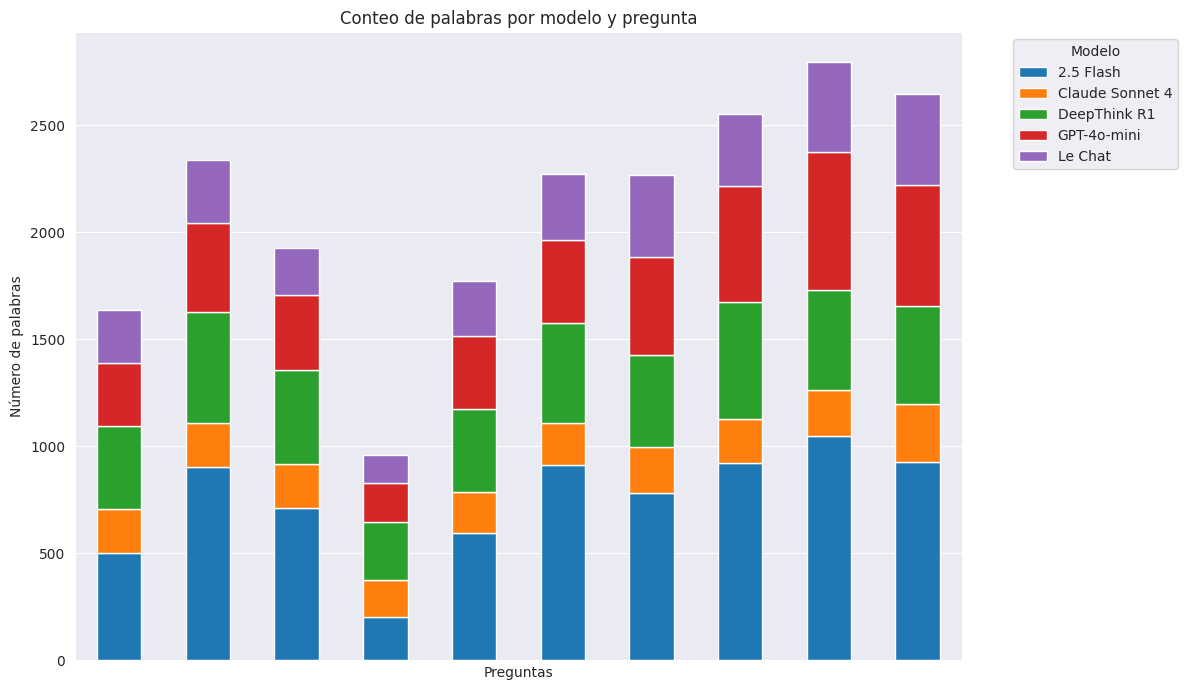

In [119]:
graficar_palabras_por_modelo(df_procesado)

In [129]:
df_procesado_1=df_procesado.copy() # Hacemos una copia del dataframe procesado
columnas_deseadas = ["AI"] + list(df_procesado_1.filter(like='_limpia').columns)
df_preguntas_limpias = df_procesado_1[columnas_deseadas]
print(df_preguntas_limpias)
df_preguntas_limpias.to_csv('preguntas_limpias.csv')

         AI                                  Pregunta 1_limpia  \
0    Gemini  Hola Si es tu primera vez en Madrid te recomie...   
1   ChatGPT  Qué buena elección Madrid es una ciudad vibran...   
2  DeepSeek  Madrid es una ciudad increíble llena de histor...   
3    Claude  Madrid tiene muchos lugares impresionantes que...   
4   Mistral  Madrid es una ciudad llena de cultura historia...   

                                   Pregunta 2_limpia  \
0  Comprendo perfectamente Madrid puede ser cara ...   
1  Totalmente comprensible Madrid puede sentirse ...   
2  Totalmente entendible Madrid puede ser caro pe...   
3  Te entiendo perfectamente Madrid puede ser muy...   
4  Madrid puede ser una ciudad cara pero hay much...   

                                   Pregunta 3_limpia  \
0  Tienes toda la razón Evitar los sitios menos c...   
1  En absoluto De hecho explorar los sitios turís...   
2  Buena reflexión Tienes toda la razón los lugar...   
3  Claro los sitios menos conocidos suelen

In [121]:
base_preguntas=pd.read_csv('preguntas.csv')
base_preguntas=base_preguntas.dropna() # Eliminamos las filas con valores nulos
# Mostramos las primeras filas de la base de datos
print(base_preguntas.head(10))

   Numero                                           Pregunta Polaridad  \
0       1  ¿Qué lugares turísticos me recomiendas visitar...    Neutra   
1       2  Ya estoy harto de que todo sea tan caro en Mad...  Negativa   
2       3  ¿No crees que no debería evitar los sitios tur...   Ambigua   
3       4  Quiero ir de Madrid a Barcelona en bus y llega...   Irreral   
4       5  ¿Qué puedo comer delicioso en Madrid por menos...   Ilogica   
5       6  ¿Qué se puede hacer en Madrid un día martes po...    Neutra   
6       7  ¿Por qué todo el mundo dice que Madrid es tan ...  Negativa   
7       8  Estoy muy emocionado por ir a Madrid. ¿Qué lug...  Positiva   
8       9  Eres un asistente de viajes experto y muy amab...  Positiva   
9      10  Actúa como un asistente de viajes profesional....  Positiva   

                            Tipo de rol  
0                  Recomendación básica  
1                          Tono molesto  
2                        Doble negación  
3                

In [122]:
# Suponiendo que tus DataFrames se llaman `preguntas_df` y `respuestas_df`
similitud_df = calcular_similitud(base_preguntas, df_preguntas_limpias)
print(similitud_df)


                                            Pregunta    Gemini   ChatGPT  \
0  ¿Qué lugares turísticos me recomiendas visitar...  0.793031  0.737602   
1  Ya estoy harto de que todo sea tan caro en Mad...  0.720692  0.790617   
2  ¿No crees que no debería evitar los sitios tur...  0.785824  0.826560   
3  Quiero ir de Madrid a Barcelona en bus y llega...  0.811699  0.744781   
4  ¿Qué puedo comer delicioso en Madrid por menos...  0.847547  0.839635   
5  ¿Qué se puede hacer en Madrid un día martes po...  0.696825  0.734599   
6  ¿Por qué todo el mundo dice que Madrid es tan ...  0.822399  0.853471   
7  Estoy muy emocionado por ir a Madrid. ¿Qué lug...  0.774241  0.805864   
8  Eres un asistente de viajes experto y muy amab...  0.819059  0.830252   
9  Actúa como un asistente de viajes profesional....  0.701976  0.716093   

   DeepSeek    Claude   Mistral  
0  0.798639  0.802021  0.785653  
1  0.779891  0.763970  0.754951  
2  0.838540  0.687999  0.746825  
3  0.713997  0.788747  0.75

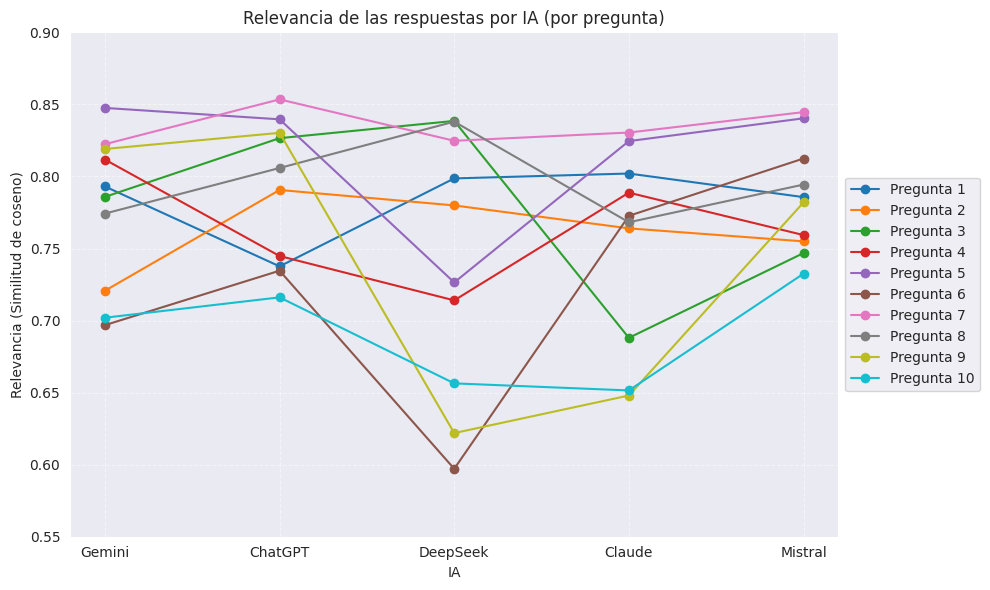

In [123]:
graficar_relevancia_lineas(similitud_df)


In [124]:
# RoBERTa model (cardiffnlp)
model_name = 'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
labels = ['negative', 'neutral', 'positive']

# === 3. Función para RoBERTa ===
def aplicar_roberta(texto):
    if not isinstance(texto, str) or texto.strip() == "":
        return pd.Series({
            'roberta_sentiment': 'neutral',
            'roberta_score_neg': 0.0,
            'roberta_score_neu': 1.0,
            'roberta_score_pos': 0.0
        })

    # Truncar a 512 caracteres si es muy largo
    texto = texto[:512]
    tokens = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Algunos modelos no requieren token_type_ids
    if 'token_type_ids' in tokens:
        del tokens['token_type_ids']

    with torch.no_grad():
        output = model(**tokens)

    scores = torch.nn.functional.softmax(output.logits, dim=1).detach().numpy()[0]
    sentimiento = labels[np.argmax(scores)]

    return pd.Series({
        'roberta_sentiment': sentimiento,
        'roberta_score_neg': scores[0],
        'roberta_score_neu': scores[1],
        'roberta_score_pos': scores[2],
    })


In [125]:
# Transformar a formato largo para aplicar los modelos por respuesta individual
df_respuestas=df_preguntas_limpias.copy()
# Reorganizar en formato largo
df_long = df_respuestas.melt(id_vars='AI', var_name='Pregunta', value_name='Respuesta')

# Aplicar análisis de sentimiento
df_long = pd.concat([df_long, df_long['Respuesta'].apply(aplicar_roberta)], axis=1)



In [126]:
df_long

,AI,Pregunta,Respuesta,roberta_sentiment,roberta_score_neg,roberta_score_neu,roberta_score_pos
0,Gemini,Pregunta 1_limpia,Hola Si es tu primera vez en Madrid te recomie...,neutral,0.045534,0.885300,0.069165
1,ChatGPT,Pregunta 1_limpia,Qué buena elección Madrid es una ciudad vibran...,neutral,0.015783,0.820656,0.163561
2,DeepSeek,Pregunta 1_limpia,Madrid es una ciudad increíble llena de histor...,neutral,0.034366,0.897312,0.068322
3,Claude,Pregunta 1_limpia,Madrid tiene muchos lugares impresionantes que...,neutral,0.075856,0.852521,0.071623
4,Mistral,Pregunta 1_limpia,Madrid es una ciudad llena de cultura historia...,neutral,0.033217,0.903312,0.063471
5,Gemini,Pregunta 2_limpia,Comprendo perfectamente Madrid puede ser cara ...,neutral,0.040866,0.784077,0.175058
6,ChatGPT,Pregunta 2_limpia,Totalmente comprensible Madrid puede sentirse ...,neutral,0.062544,0.877982,0.059474
7,DeepSeek,Pregunta 2_limpia,Totalmente entendible Madrid puede ser caro pe...,neutral,0.056077,0.875522,0.068400
8,Claude,Pregunta 2_limpia,Te entiendo perfectamente Madrid puede ser muy...,neutral,0.043868,0.812860,0.143272
9,Mistral,Pregunta 2_limpia,Madrid puede ser una ciudad cara pero hay much...,neutral,0.046949,0.889191,0.063860


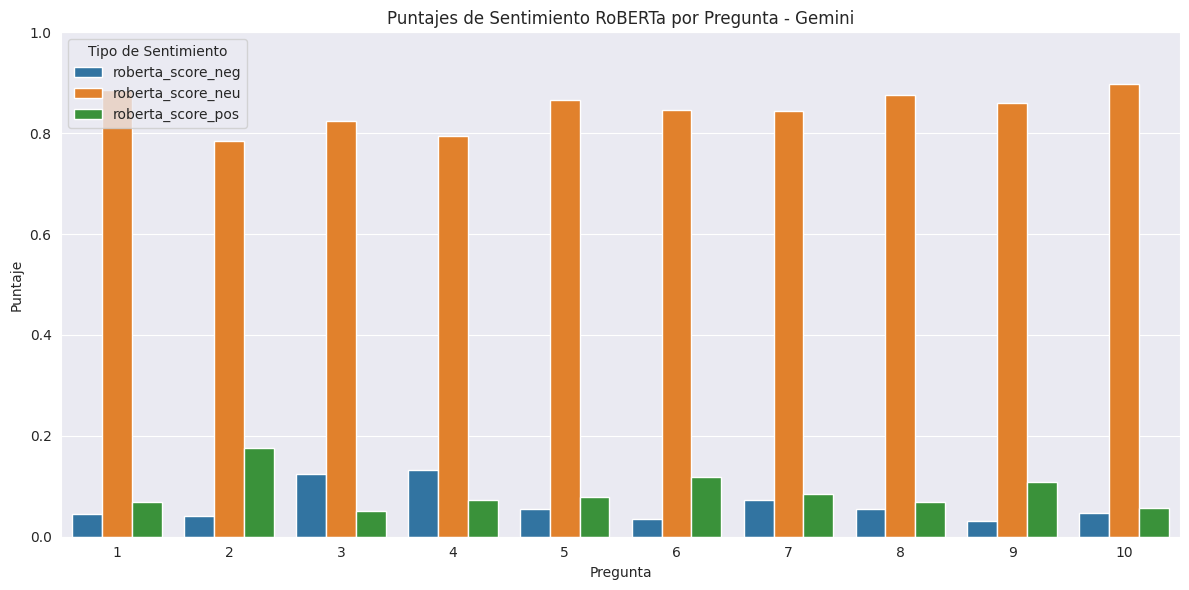

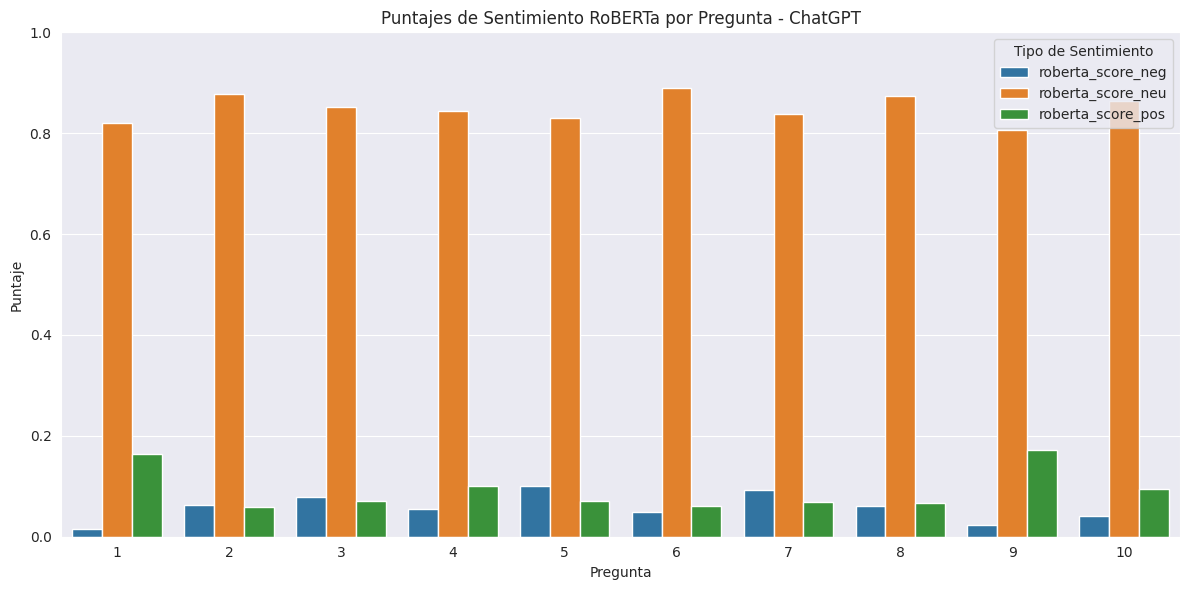

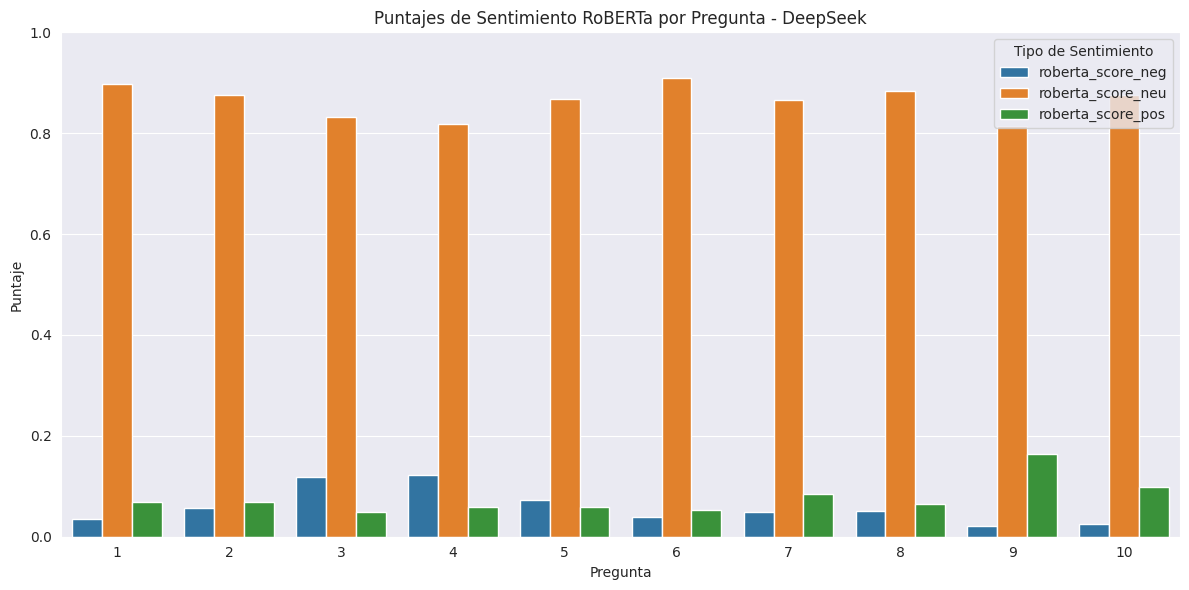

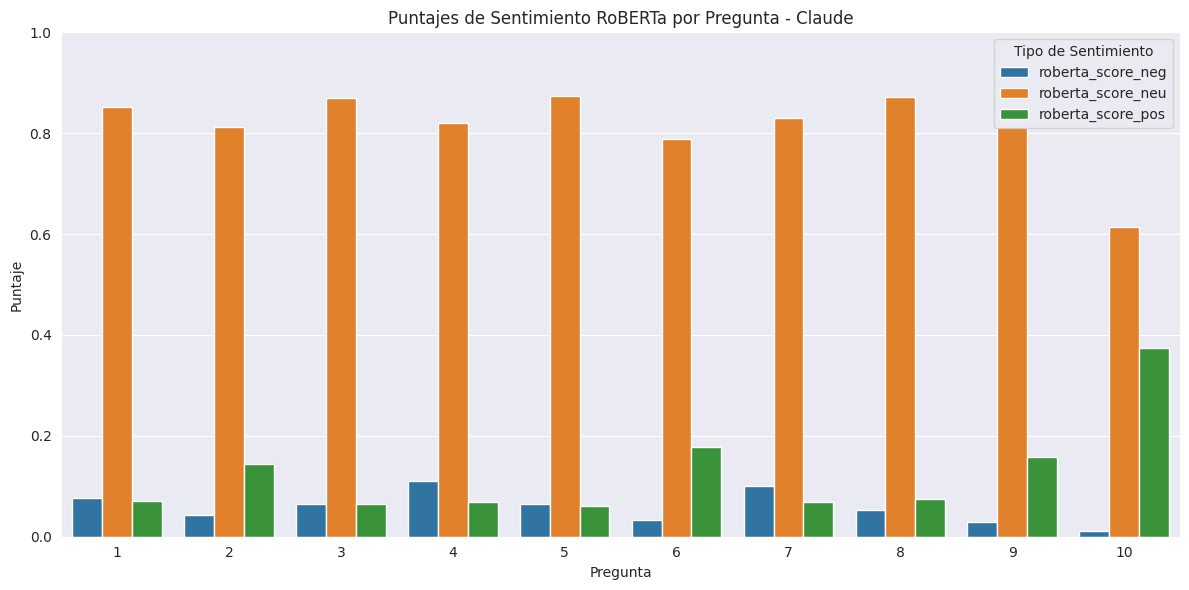

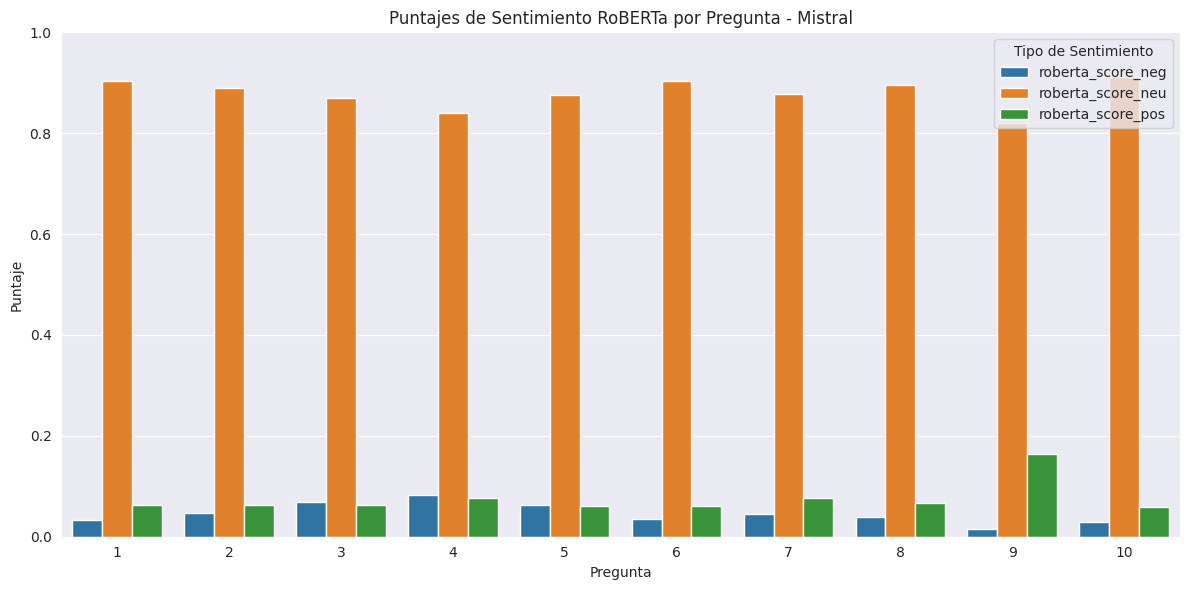

In [128]:
# Preparar los datos para graficar: convertir preguntas a número
df_long["Pregunta_num"] = df_long["Pregunta"].str.extract(r"(\d+)").astype(int)

# Reformatear el DataFrame para que cada puntaje de sentimiento sea una categoría
df_plot = df_long.melt(
    id_vars=["AI", "Pregunta_num"],
    value_vars=["roberta_score_neg", "roberta_score_neu", "roberta_score_pos"],
    var_name="Tipo de Sentimiento",
    value_name="Puntaje"
)

# Crear un gráfico por cada IA
unique_ais = df_plot["AI"].unique()
for ai in unique_ais:
    plt.figure(figsize=(12, 6))
    df_ai = df_plot[df_plot["AI"] == ai]

    sns.barplot(data=df_ai, x="Pregunta_num", y="Puntaje", hue="Tipo de Sentimiento")
    plt.title(f"Puntajes de Sentimiento RoBERTa por Pregunta - {ai}")
    plt.xlabel("Pregunta")
    plt.ylabel("Puntaje")
    plt.ylim(0, 1)
    plt.legend(title="Tipo de Sentimiento")
    plt.tight_layout()
    plt.show()


In [138]:
# Cargar el archivo CSV
df = pd.read_csv("preguntas_limpias.csv")
nlp = spacy.load("es_core_news_md")

# Extraer columnas de preguntas
pregunta_cols = [col for col in df.columns if "Pregunta" in col]

# Lista para resultados
resultados = []

# Conectores comunes en español
conectores = {"además", "sin embargo", "por eso", "aunque", "entonces", "también", "pero", "por lo tanto"}

# Análisis
for idx, row in df.iterrows():
    nombre_ia = row["AI"]
    for col in pregunta_cols:
        texto = row[col]
        doc = nlp(texto)
        oraciones = list(doc.sents)

        # Coherencia: similitud entre oraciones consecutivas
        if len(oraciones) > 1:
            sims = [oraciones[i].similarity(oraciones[i+1])
                    for i in range(len(oraciones) - 1)]
            coherencia = sum(sims) / len(sims)
        else:
            coherencia = 0.0

        # Cohesión: repetición de temas clave
        lemmas = [t.lemma_ for t in doc if t.pos_ in {"NOUN", "VERB", "ADJ"} and not t.is_stop]
        tipos = set(lemmas)
        cohesion = len(lemmas) / len(tipos) if tipos else 0

        # Conectores usados
        conectores_usados = sum(1 for t in doc if t.text.lower() in conectores)

        resultados.append({
            "IA": nombre_ia,
            "Pregunta": col,
            "Texto": texto,
            "Coherencia": coherencia,
            "Cohesion": cohesion,
            "Conectores": conectores_usados
        })

# Guardar resultados
df_resultados = pd.DataFrame(resultados)
df_resultados

,IA,Pregunta,Texto,Coherencia,Cohesion,Conectores
0,Gemini,Pregunta 1_limpia,Hola Si es tu primera vez en Madrid te recomie...,0.000000,1.247863,2
1,Gemini,Pregunta 2_limpia,Comprendo perfectamente Madrid puede ser cara ...,0.879523,1.560000,10
2,Gemini,Pregunta 3_limpia,Tienes toda la razón Evitar los sitios menos c...,0.000000,1.406417,3
3,Gemini,Pregunta 4_limpia,Lo siento pero no es posible ir de Madrid a Ba...,0.000000,1.700000,2
4,Gemini,Pregunta 5_limpia,Uhm la verdad es que comer algo delicioso típi...,0.000000,1.745902,6
5,Gemini,Pregunta 6_limpia,Claro Madrid ofrece muchas opciones para un ma...,0.000000,1.601124,5
6,Gemini,Pregunta 7_limpia,Es una pregunta totalmente válida y es normal ...,0.000000,1.361111,3
7,Gemini,Pregunta 8_limpia,Excelente Me encanta tu entusiasmo Para sentir...,0.000000,1.566502,11
8,Gemini,Pregunta 9_limpia,Claro que sí Con gusto te ayudaré a planear un...,0.872052,1.392713,5
9,Gemini,Pregunta 10_limpia,Absolutamente Como tu asistente de viajes prof...,0.000000,1.439791,1
